In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import (
    LSTM,
    Attention,
    BatchNormalization,
    Bidirectional,
    Concatenate,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    GlobalMaxPooling1D,
    Input,
    Layer,
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer

# Load the training data
train_data = pd.read_csv("train.csv")
validation_data = pd.read_csv("validate.csv")
test_data = pd.read_csv("test.csv")

# Prepare data
X_train = train_data.drop(columns=["genre"])
y_train = train_data["genre"]
X_val = validation_data.drop(columns=["genre"])
y_val = validation_data["genre"]
X_test = test_data.drop(columns=["ID"])

# Normalize input features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)

# Define label encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)


# Load the training text data
with open("train.txt", "r", encoding="utf-8") as file:
    train_texts = file.readlines()


# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_encoded), y=y_train_encoded
)


# Define custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight", shape=(input_shape[-1], 1), initializer="normal"
        )
        self.b = self.add_weight(
            name="att_bias", shape=(input_shape[1], 1), initializer="zeros"
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(
            tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b), axis=-1
        )
        at = tf.keras.backend.softmax(et, axis=-1)
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x * at
        return tf.keras.backend.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


# Define model
def build_model(
    input_shape, output_classes, hidden_layers, hidden_nodes, learning_rate
):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(hidden_nodes, activation="relu", input_shape=input_shape)
    )
    for _ in range(hidden_layers - 1):
        model.add(tf.keras.layers.Dense(hidden_nodes, activation="relu"))
    model.add(tf.keras.layers.Dense(output_classes, activation="softmax"))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Evaluate model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_val_pred = np.argmax(model.predict(X_val), axis=1)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    print("Accuracy Scores:")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Validation Accuracy: {val_accuracy}")

    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))


# Model parameters
input_shape = (X_train.shape[1],)
output_classes = len(label_encoder.classes_)
print(label_encoder.classes_)
hidden_layers = 1
hidden_nodes = 64
learning_rate = 0.001
epochs = 100

# Build and train the model
model = build_model(
    input_shape, output_classes, hidden_layers, hidden_nodes, learning_rate
)

history = model.fit(
    X_train,
    y_train_encoded,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    verbose=1,
    class_weight=dict(enumerate(class_weights)),
)

# Evaluate the model
evaluate_model(model, X_train, y_train_encoded, X_val, y_val_encoded)

# Make predictions on test set
test_predictions = np.argmax(model.predict(X_test), axis=1)

# Create submission DataFrame
submission_df = pd.DataFrame({"ID": test_data["ID"], "label": test_predictions})

# Save submission to CSV
submission_df.to_csv("submission.csv", index=False)

['action' 'comedy' 'documentary' 'drama' 'horror' 'thriller']
Epoch 1/100


/Users/chinemerem/Documents/GitHub/ECE457B/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - accuracy: 0.1973 - loss: 1.7873 - val_accuracy: 0.2735 - val_loss: 1.7333
Epoch 2/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.3945 - loss: 1.6082 - val_accuracy: 0.3967 - val_loss: 1.5400
Epoch 3/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.4745 - loss: 1.4315 - val_accuracy: 0.4791 - val_loss: 1.3831
Epoch 4/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5309 - loss: 1.3079 - val_accuracy: 0.5756 - val_loss: 1.2088
Epoch 5/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.5562 - loss: 1.2351 - val_accuracy: 0.5554 - val_loss: 1.2499
Epoch 6/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.5674 - loss: 1.1892 - val_accuracy: 0.5712 - val_loss: 1.2011
Epoch 7/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.5857 - loss: 1.1512 - val_accuracy: 0.5329 - val_loss: 1.2522
Epoch 8/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.5996 - loss: 1.1166 - val_

KeyboardInterrupt: 

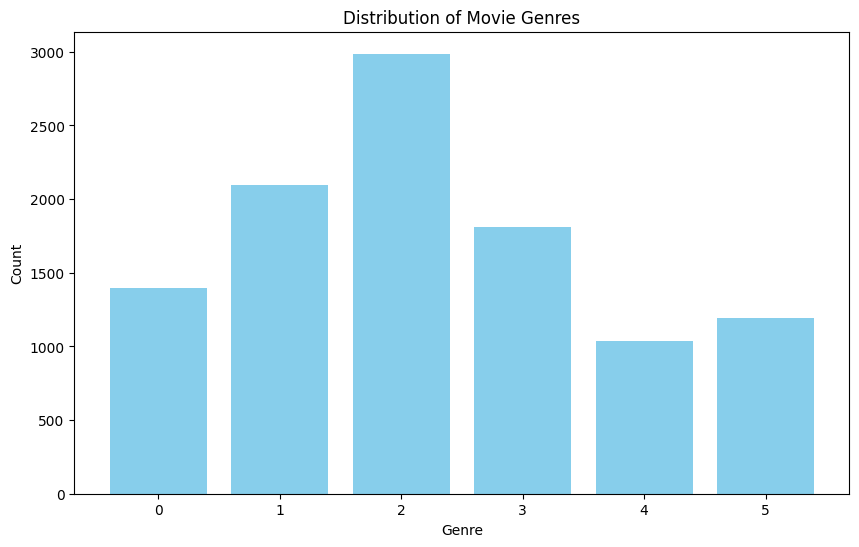

In [25]:

# Count the occurrences of each genre
genre_counts = submission_df["label"].value_counts()


# Plot the distribution of genres
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color="skyblue")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Distribution of Movie Genres")
plt.xticks(genre_counts.index, genre_counts.index.tolist())
plt.show()

Drama and documentary genres are the most common, with 5483 and 4861
occurrences, respectively. Comedy is the third most common genre with 3896
occurrences.Horror, thriller, and action genres have fewer occurrences compared
to drama, documentary, and comedy, with 2104, 1568, and 1312 occurrences,
respectively. The distribution of the dataset is imbalanced, with drama and
documentary genres dominating the dataset, while horror, thriller, and action
genres are underrepresented. This class imbalance can potentially affect the
performance of machine learning models, particularly for genres with fewer
occurrences, as the model may struggle to generalize well to these classes.